In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#1 cmf = 28316.847 ml/min
# multiply by the following to convert to ml/min
cfm_to_mlmin = 28316.847

#cfm_to_mlmin = 28320

In [146]:
class air_dat:
    
    def __init__(self, **kwargs):
        
        
        self.monitor = {'hall_a':'AirMon_A', 
                             'hall_c':'AirMon_C', 
                             'hall_b':'AirMon_B', 
                             'hall_d':'AirMon_D', 
                             'L':'AirMon_L', 
                             'SL':'AirMon_SL', 
                             'BSY':'AirMon_BSY'}
        
        self.current = {'hall_a':'C_A(uA)', 
                             'hall_c':'C_C(uA)', 
                             'hall_b':'C_B(uA)', 
                             'hall_d':'C_D(nA)', 
                             'BSY':'C_BSY(uA)'}
        
        self.energy = {'hall_a':'E_A(MeV)', 
                       'hall_c':'E_C(MeV)', 
                       'hall_b':'E_B(MeV)', 
                       'hall_d':'E_C(MeV)', 
                       'BSY':'E_A(MeV)'}
        
        if ('threshold' in kwargs):
            self.threshold = kwargs['threshold']
        else:
            self.threshold = 1e-6
            
            
        if ('ventilation' in kwargs):
            self.ventilation = kwargs['ventilation']
        else:
            self.ventilation = 1000    
            
        print("Ventilation Rate: {} cfm".format(self.ventilation))
            


    def get_data(self, fle_name='./ans2020_Jul29_Sep22_2.airdat.txt', dt_start='07/29/2021 00:00:00'):
        self.fle_name = fle_name
        
        
        air_df = pd.read_csv(fle_name, delimiter='\s+')

        dte_start = datetime.datetime.strptime(dt_start, '%m/%d/%Y %H:%M:%S')
        self.dte_start = dte_start
        
        print(air_df.keys())
        
        air_df['DATE_TIME'] = air_df['Time(min)'].apply(lambda x: datetime.timedelta(minutes=x) + dte_start)
        air_df    
        return air_df
    
    def get_date_df(self, air_df):
        """
        set_date_df(self, air_df)
        
        return a dataframe with just the DATE_TIME field for use in merging
        """
        dt_df = pd.DataFrame(air_df['DATE_TIME'])
        return dt_df

    def apply_threshold(self, air_df, key='hall_c', sigma_method=True, repl_mean=True, replace_zero=True):
        air_df_sub = air_df[self.monitor[key]]
        #air_df = air_df[air_df_sub < self.threshold]
        print("Applying threshold to data: {:2.2e} uCi/ml".format(self.threshold))
        
        print("length before thresholding: {}".format(len(air_df)))
        test_res = air_df_sub > self.threshold
        
        print("Reject {} using threshold".format(len(test_res[test_res == True])))
        
        
        air_df.loc[test_res, [self.monitor[key]]] = 0
        
        # if we choose we can reject the mean + 3 sigma values once the 
        if (sigma_method):
            print("Replace greater than 3 sigma with mean value")
            threshold = (air_df_sub[air_df_sub <= self.threshold].std() * 3 + 
                         air_df_sub[air_df_sub <= self.threshold].mean())
            
            sigma_test_res = air_df_sub > threshold
            print("Found {} values using > 3*sigma".format(len(test_res[sigma_test_res == True])))
            
            air_df.loc[sigma_test_res, [self.monitor[key]]] = 0
            
            test_res = test_res | sigma_test_res
            
        
        
        # Replace our thresholded rejection with the mean of the remainder of the dataset
        if (repl_mean):
            print("Replacing thresholded rejection with mean value")
            mn = air_df[self.monitor[key]].mean()

            print("Mean value replacement: {:2.2e} uCi/ml".format(mn))

            air_df.loc[test_res, [self.monitor[key]]] = mn

            
            
        if (replace_zero):
            
            threshold = ( air_df_sub[air_df_sub <= self.threshold].mean() - 
                         air_df_sub[air_df_sub <= self.threshold].std() * 3)            
            
            print("Replace less than 3 sigma with mean value")
            mn = air_df[self.monitor[key]].mean()
            test_res = air_df[self.monitor[key]] < threshold
            print("Found {} zero values using < 3*sigma".format(len(test_res[test_res == True])))
            air_df.loc[test_res, [self.monitor[key]]] = mn         
        

        print("length after thresholding: {}".format(len(air_df)))

        return air_df
    
    
    def get_loc_bkg(self, air_df, key='hall_c', pad=0, show_hist=True, current_limit=1, clean_bkg=True):
        # get the background data for the location using a padding following current-on to allow for decay

        
        full_len = len(air_df[self.current[key]])
        
        print("Full Data length: {}".format(full_len))        
        active_cur = air_df[air_df[self.current[key]] > current_limit][self.current[key]]
        
        idx = active_cur.index.values

        print("Original Current-On Data length: {}".format(len(air_df.loc[idx])))   
        
        cur_index = air_df.index.isin(idx)
        
        for i in range(1,pad):
            cur_index = cur_index | air_df.index.isin(idx+i)


        bkg_index = ~cur_index   
                
        idx = np.sort(idx)
        print("Current-on Data length after pad={}: {}".format(pad, len(air_df[cur_index])))
        current_steps = len(air_df[cur_index])
        

        
        bkg = air_df.loc[bkg_index, ['DATE_TIME', 
                                   self.current[key], 
                                   self.monitor[key], 
                                   self.energy[key]]]
        
        # set any zeros to average background, helps with tail points that seem to alway be 0's
        if (clean_bkg):
            bkg.loc[bkg[self.monitor[key]] <=1e-8, [self.monitor[key]]] = bkg[self.monitor[key]].mean()
                
        
        cur = air_df.loc[cur_index, ['DATE_TIME', 
                                   self.current[key], 
                                   self.monitor[key], 
                                   self.energy[key]]]        
        
        
        
        full_data = air_df[['DATE_TIME', 
                                   self.current[key], 
                                   self.monitor[key], 
                                   self.energy[key]]]   
        
        if (show_hist):
            plt.figure()
            fig, ax = plt.subplots()
            bkg[self.monitor[key]].hist(alpha=0.5, label='bkg_'+key, ax=ax, bins=50)
            cur[self.monitor[key]].hist(alpha=0.5, label='monitor_'+key, ax=ax, bins=50)
            ax.set_title("Air Monitor Distribution: {}".format(key))
            ax.set_xlabel("Concentration ($\mu/ml$)")
            ax.set_ylabel
            ax.legend()  
            plt.show()
        
        
        return full_data, cur, bkg, current_steps
    
    def normalize_get_net(self, dt_df, cur, bkg, key, no_neg=True, plot=True, use_mn_bkg=False, use_val_bkg=False, usr_mn=0.):
        
        bkg = bkg.rename(columns={self.monitor[key]:self.monitor[key]+'_Bkg'} )
        
        if (use_mn_bkg):
            bkg = pd.DataFrame(bkg).set_index('DATE_TIME').resample('30Min').asfreq()
            bkg_mn = bkg[self.monitor[key]+'_Bkg'].mean()
            print("Current-on background set to mean {:2.2e} uCi/ml".format(bkg_mn))
            bkg[self.monitor[key]+'_Bkg'] = bkg[self.monitor[key]+'_Bkg'].replace(np.nan,bkg_mn)
            
        elif (use_val_bkg):
            bkg = pd.DataFrame(bkg).set_index('DATE_TIME').resample('30Min').asfreq()
            print("Current-on background set to user value {:2.2e} uCi/ml".format(usr_mn))
            bkg[self.monitor[key]+'_Bkg'] = bkg[self.monitor[key]+'_Bkg'].replace(np.nan,usr_mn)            
        else:
            bkg = pd.DataFrame(bkg).set_index('DATE_TIME').resample('30Min').interpolate(method='linear')
        bkg_df = dt_df.merge(bkg, left_on='DATE_TIME', right_on='DATE_TIME', how='left')
        
        cur = cur.rename(columns={self.monitor[key]:self.monitor[key]+'_Cur'} )
        #cur = pd.DataFrame(cur).set_index('DATE_TIME').resample('30Min').interpolate(method='linear')
        cur_df = dt_df.merge(cur, left_on='DATE_TIME', right_on='DATE_TIME', how='left') 
        
        #dt_df[self.monitor[key]+'_Cur'] = cur_df[self.monitor[key]+'_Cur']
        
        
        dt_df[self.monitor[key]+'_Bkg'] = bkg_df[self.monitor[key]+'_Bkg']
        dt_df = dt_df.merge(cur_df, how='left', left_on='DATE_TIME', right_on='DATE_TIME')
        
        
        
        dt_df['net_'+key] = dt_df[self.monitor[key]+'_Cur'] - dt_df[self.monitor[key]+'_Bkg']
        
        if (no_neg):
            dt_df.loc[dt_df['net_'+key] < 0, ['net_'+key]] = 0
        
        if (plot):
            plt.figure()
            fig, ax = plt.subplots()
            dt_df.plot(x='DATE_TIME', y='net_'+key, ax=ax)
            ax.set_title("Net Concentration")
            plt.xticks(rotation=45)            
            plt.show()
        
        return dt_df
    
    def total_activity(self, full_df, key, steps, t_step_min=60):
        mins = t_step_min
        concentration = full_df['net_'+key].sum()
        
        total = concentration * mins * cfm_to_mlmin * self.ventilation
        print("Hours run: {:2.2e}".format(mins*steps))
        print("Fraction of a year: {:2.2f}".format(mins*steps / (365.24*24*60)))
        print("Sum of concentration: {:2.2e} uCi/ml".format(concentration))
        print("Total: {:2.2e} uCi".format(total))
        return total
    
    def normalize(self, df, key, net_set=True, use_net_res=True):
        net_key = 'net_' + key
        cur_hall_key = self.current[key]
        ene_hall_key = self.energy[key]
        air_hall_key = self.monitor[key]
        
        if (net_set):
            air_hall_key = air_hall_key + "_Cur"
        
        norm_c = df[cur_hall_key]/ df[cur_hall_key].max()
        norm_p = (df[ene_hall_key]*df[cur_hall_key])/ (df[ene_hall_key]*df[cur_hall_key]).max()
        
        if (use_net_res):
            norm_air = df[net_key]/ df[net_key].max()
        else:
            norm_air = df[air_hall_key] / df[air_hall_key].max()

        df['norm_'+key] = norm_c
        df['norm_air_'+key] = norm_air

        #full.plot(x='DATE_TIME', )
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))
        ax[0][0].plot(df['DATE_TIME'], norm_c, 'o-', label='Normalized Current', alpha=0.5)
        ax[0][0].plot(df['DATE_TIME'], norm_air, 'o-', label='Normalized Concentration', alpha=0.5)
        ax[0][0].set_title("Normalized Current and Net Concentration")
        ax[0][0].legend()

        ax[0][1].plot(df['DATE_TIME'], norm_p, label='Normalized Power')
        ax[0][1].plot(df['DATE_TIME'], norm_air, label='Normalized Concentration')
        ax[0][1].set_title("Normalized Power and Net Concentration")
        ax[0][1].legend()
        
        ax[1][0].plot(norm_p, norm_air, 'x', label='Normalized Airborne')
        ax[1][0].set_title("Airborned Concentration vs. Current")    
        ax[1][0].legend()        


        ax[1][1].plot(norm_p, norm_air, 'x', label='Normalized Airborne')
        ax[1][1].set_title("Airborned Concentration vs. Power")
        ax[1][1].legend()
        plt.show()
        
        return df
        
        
        
    
    
    def generate_plots(self, df, key, net_set=True,):
        print("Generating standard plots")
        
        net_key = 'net_' + key
        cur_hall_key = self.current[key]
        ene_hall_key = self.energy[key]
        air_hall_key = self.monitor[key]

        
        if (net_set):
            air_cur_key = air_hall_key + "_Cur"
            air_bkg_key = air_hall_key + "_Bkg"
        
            fig, ax = plt.subplots(figsize=(20,10), nrows=2, sharex=True)
            ax[0].plot(df['DATE_TIME'], df[air_cur_key], 'o-', alpha=0.5, label='Current On')
            ax[0].plot(df['DATE_TIME'], df[air_bkg_key], 'o-', alpha=0.5, label='Background')
            ax[0].ticklabel_format(style='sci', axis='y', useOffset=False)
            ax[0].set_title("Calculated Airborne Concentrations")
            ax[0].legend()

            ax[1].plot(df['DATE_TIME'], df[net_key], 'o-', alpha=0.5, label="Net Signal")
            ax[1].set_title("Net Airborne Concentration $\mu Ci/ml$")
            ax[1].legend()
            ax[1].ticklabel_format(style='sci', axis='y', useOffset=False)      
            plt.show()
            
        else:
            
            fig, ax = plt.subplots(figsize=(20,10))
            ax.plot(df['DATE_TIME'], df[air_hall_key], 'o-', alpha=0.5, label='Air Monitor')
            ax.legend()
            ax.set_title("Air Monitor Result")
            plt.show()
        
        
        
        


In [354]:
air = air_dat(threshold=1e-5)
air_df = air.get_data(fle_name="./ans2020_Jan01_Mar31_wBSY.airdat.txt", dt_start='01/01/2021 00:00:00')
#air_df = air.get_data(fle_name="./ans2020_Jul29_Sep22_2.airdat.txt, dt_start='07/01/2021 00:00:00'")

hall = 'hall_a'
air_hall_key = air.monitor[hall]
cur_hall_key = air.current[hall]
ene_hall_key = air.energy[hall]


Ventilation Rate: 1000 cfm
Index(['Time(min)', 'E_A(MeV)', 'C_A(uA)', 'AirMon_A', 'E_C(MeV)', 'C_C(uA)',
       'AirMon_C', 'C_BSY(uA)', 'AirMon_BSY', 'AirMon_B', 'C_D(nA)',
       'AirMon_D', 'AirMon_L', 'AirMon_SL', 'IPM1C01', 'IPM1C02', 'IPM2C01',
       'IPM2C02', 'IPM3C01', 'IPM3C02'],
      dtype='object')


In [373]:
air_df[['IPM1C01', 'IPM1C02', 'IPM2C01',
       'IPM2C02', 'IPM3C01', 'IPM3C02']]

,IPM1C01,IPM1C02,IPM2C01,IPM2C02,IPM3C01,IPM3C02
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2163,0.0,0.0,0.0,0.0,0.0,0.0
2164,0.0,0.0,0.0,0.0,0.0,0.0
2165,0.0,0.0,0.0,0.0,0.0,0.0
2166,0.0,0.0,0.0,0.0,0.0,0.0


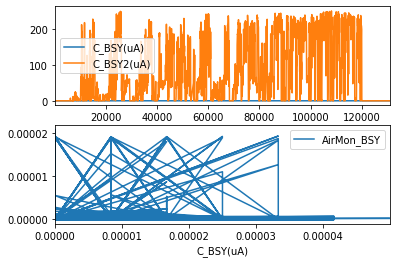

In [368]:
air_df['C_BSY2(uA)'] = air_df.apply(lambda x: np.max([x['IPM1C01'], x['IPM1C02'], x['IPM2C01'], x['IPM2C02'], x['IPM3C01'], x['IPM3C02']]), axis=1)
fig, ax = plt.subplots(ncols=1, nrows=2)
air_df.plot(x='Time(min)', y=['C_BSY(uA)', 'C_BSY2(uA)'], ax=ax[0])

air_df.plot(x='C_BSY(uA)', y=['AirMon_BSY'], ax=ax[1])

In [355]:
repl_mean = True # used in apply_threshold to replace zeros with the overall mean value for all data
sigma_method = True # used in apply_threshold to replace  > 3 sigma with the overall mean value for all data
replace_zero = True # used in apply_threshold to replace  < 3 sigma with the overall mean value for all data

pad = 10 # used in get_loc_bkg to determine how long after beam to associate with current on, in steps not time
current_limit = .01 # used in get_loc_bkg to determine if current is on or off

# note default method for bkg correction in normalize_get_net is linear interpolation between single nearest data
no_neg = True # used in normalize_get_net to replace negative net values with 0 otherwise keep negatives
use_mn_bkg=False # used in normalize_get_net to set background values for current-on to the background mean
use_val_bkg=False # used in normalize_get_net to set background values for current-on to a user-specified value
usr_mn=1.87e-7 # used in normalize_get_net when use_val_bkg is true, 0. is the default (no background subtraction)


In [356]:
air_df = air.apply_threshold(air_df, key=hall,
                             repl_mean=repl_mean,
                             sigma_method=sigma_method,
                             replace_zero=replace_zero)

Applying threshold to data: 1.00e-05 uCi/ml
length before thresholding: 2168
Reject 26 using threshold
Replace greater than 3 sigma with mean value
Found 18 values using > 3*sigma
Replacing thresholded rejection with mean value
Mean value replacement: 3.42e-07 uCi/ml
Replace less than 3 sigma with mean value
Found 0 zero values using < 3*sigma
length after thresholding: 2168


In [328]:

# get the current (val), background (bkg) data into separate dataframes based on padding and current limits for a hall
# anything above the current_limit assumes beam on target

full, val, bkg, current_steps = air.get_loc_bkg(air_df, key=hall, 
                                                pad=pad, 
                                                show_hist=False, 
                                                current_limit=current_limit)





Full Data length: 2168
Original Current-On Data length: 1288
Current-on Data length after pad=10: 1585


In [329]:
dt_df = pd.DataFrame(air_df['DATE_TIME'])


full = air.normalize_get_net(dt_df, val, bkg, 
                             key=hall, 
                             no_neg=no_neg, 
                             plot=False, 
                             use_mn_bkg=use_mn_bkg, 
                             use_val_bkg=use_val_bkg, 
                             usr_mn=usr_mn)

total_uCi = air.total_activity(full, hall, current_steps, t_step_min=60 )
print("Total Activity from {}: {:2.2e} uCi".format(hall, total_uCi))


# plt.figure()
# fig, ax = plt.subplots(figsize=(20,10))
# val.plot(x='DATE_TIME', y=air.monitor[hall], ax=ax, label='monitor'+hall, marker='o', linestyle='none')
# bkg.plot(x='DATE_TIME', y=air.monitor[hall], ax=ax, label='bkg_'+hall, marker='o', linestyle='none')
# ax.set_title("Airborne Concentrations ($\mu Ci/ml$): "+hall)
# plt.savefig(os.path.join(os.getcwd(), "AirMonitor_Bkg_"+hall+".jpg"))

Hours run: 9.51e+04
Fraction of a year: 0.18
Sum of concentration: 4.14e-04 uCi/ml
Total: 7.03e+05 uCi
Total Activity from hall_a: 7.03e+05 uCi


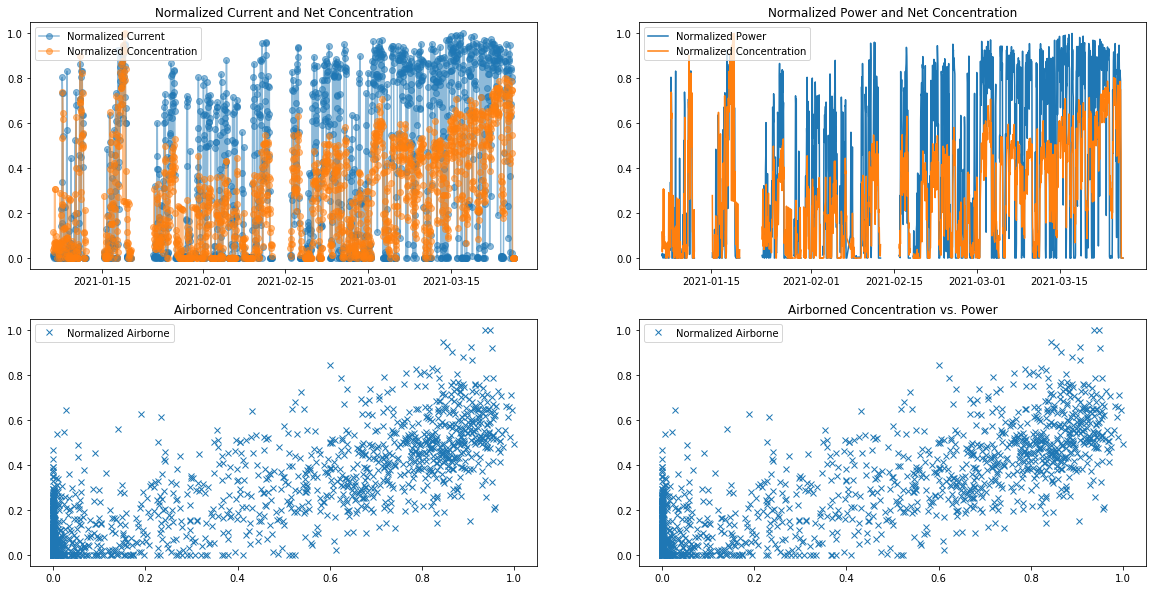

,DATE_TIME,AirMon_A_Bkg,C_A(uA),AirMon_A_Cur,E_A(MeV),net_hall_a,norm_hall_a,norm_air_hall_a
0,2021-01-01 00:30:00,9.578478e-08,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 01:30:00,9.854823e-08,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 02:30:00,1.409705e-07,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 03:30:00,9.095065e-08,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 04:30:00,6.668227e-08,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2163,2021-04-01 19:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2164,2021-04-01 20:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2165,2021-04-01 21:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2166,2021-04-01 22:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0


In [330]:
df = air.normalize(full, hall, net_set=True, use_net_res=True)
df = df.replace(np.nan, 0)
df

# Begin ML 

In [331]:
import tensorflow as tf
from keras.layers import LSTM

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations

In [332]:


#ml_df =df.loc[((df['C_A(uA)'] > 1) & (df['net_hall_a'] > 0 ))]
ml_df =df.loc[((df['net_hall_a'] >= 0 ))]


x = np.array(0)
ml_arrays = [(ml_df['C_A(uA)'] / ml_df['C_A(uA)'].max()).values ]


y = ml_df['net_hall_a'].values
y = y/y.max()

tsteps = 10
for step in range(tsteps):
    ml_array = np.append(x, y[:len(y)-step-1] )
    x = np.append(x, 0)

    ml_arrays.append(ml_array)
    print("Added range {}".format(step+1))
    
ml_arrays = np.asarray(ml_arrays)

np.shape(ml_arrays)

Added range 1
Added range 2
Added range 3
Added range 4
Added range 5
Added range 6
Added range 7
Added range 8
Added range 9
Added range 10


(11, 2168)

In [333]:
t_val = []
for i in range(np.shape(ml_arrays)[1]):
    row = []
    for j in range(np.shape(ml_arrays)[0]):
        row.append(ml_arrays[j][i])
    t_val.append(row)
        
t_val
trainX = np.asarray(t_val)
np.shape(trainX)

(2168, 11)

In [344]:
model = Sequential()

model.add(LSTM(1,input_shape=(np.shape(trainX)[1],1), return_sequences=True))
model.add(LSTM(3))
model.add(Dense(100, activation=activations.relu))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 11, 1)             12        
_________________________________________________________________
lstm_29 (LSTM)               (None, 3)                 60        
_________________________________________________________________
dense_26 (Dense)             (None, 100)               400       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 573
Trainable params: 573
Non-trainable params: 0
_________________________________________________________________


In [345]:
model.fit(trainX.reshape(np.shape(trainX)[0],np.shape(trainX)[1] ,1), y, epochs=300, batch_size=100, verbose=1)

Epoch 1/300
2168/2168 [==============================] - 3s 1ms/step - loss: 0.0653
Epoch 2/300
2168/2168 [==============================] - 0s 141us/step - loss: 0.0418
Epoch 3/300
2168/2168 [==============================] - 0s 140us/step - loss: 0.0325
Epoch 4/300
2168/2168 [==============================] - 0s 146us/step - loss: 0.0201
Epoch 5/300
2168/2168 [==============================] - 0s 140us/step - loss: 0.0157
Epoch 6/300
2168/2168 [==============================] - 0s 146us/step - loss: 0.0144
Epoch 7/300
2168/2168 [==============================] - 0s 138us/step - loss: 0.0133
Epoch 8/300
2168/2168 [==============================] - 0s 140us/step - loss: 0.0122
Epoch 9/300
2168/2168 [==============================] - 0s 140us/step - loss: 0.0112
Epoch 10/300
2168/2168 [==============================] - 0s 144us/step - loss: 0.0102
Epoch 11/300
2168/2168 [==============================] - 0s 158us/step - loss: 0.0094
Epoch 12/300
2168/2168 [==============================

2168/2168 [==============================] - 0s 186us/step - loss: 0.0051
Epoch 96/300
2168/2168 [==============================] - 0s 148us/step - loss: 0.0050
Epoch 97/300
2168/2168 [==============================] - 0s 178us/step - loss: 0.0050
Epoch 98/300
2168/2168 [==============================] - 0s 159us/step - loss: 0.0050
Epoch 99/300
2168/2168 [==============================] - 0s 141us/step - loss: 0.0052
Epoch 100/300
2168/2168 [==============================] - 0s 150us/step - loss: 0.0051
Epoch 101/300
2168/2168 [==============================] - 0s 157us/step - loss: 0.0050
Epoch 102/300
2168/2168 [==============================] - 0s 164us/step - loss: 0.0050
Epoch 103/300
2168/2168 [==============================] - 0s 149us/step - loss: 0.0050
Epoch 104/300
2168/2168 [==============================] - 0s 149us/step - loss: 0.0051
Epoch 105/300
2168/2168 [==============================] - 0s 147us/step - loss: 0.0050
Epoch 106/300
2168/2168 [=========================

2168/2168 [==============================] - 0s 180us/step - loss: 0.0051
Epoch 189/300
2168/2168 [==============================] - 0s 148us/step - loss: 0.0052
Epoch 190/300
2168/2168 [==============================] - 0s 167us/step - loss: 0.0052 0s - loss: 0.
Epoch 191/300
2168/2168 [==============================] - 0s 143us/step - loss: 0.0051
Epoch 192/300
2168/2168 [==============================] - 0s 159us/step - loss: 0.0049
Epoch 193/300
2168/2168 [==============================] - 0s 172us/step - loss: 0.0050
Epoch 194/300
2168/2168 [==============================] - 0s 141us/step - loss: 0.0049
Epoch 195/300
2168/2168 [==============================] - 0s 149us/step - loss: 0.0049
Epoch 196/300
2168/2168 [==============================] - 0s 166us/step - loss: 0.0049
Epoch 197/300
2168/2168 [==============================] - 0s 137us/step - loss: 0.0049
Epoch 198/300
2168/2168 [==============================] - 0s 163us/step - loss: 0.0050
Epoch 199/300
2168/2168 [=======

2168/2168 [==============================] - 0s 196us/step - loss: 0.0049
Epoch 282/300
2168/2168 [==============================] - 0s 135us/step - loss: 0.0049
Epoch 283/300
2168/2168 [==============================] - 0s 138us/step - loss: 0.0050
Epoch 284/300
2168/2168 [==============================] - 0s 153us/step - loss: 0.0050
Epoch 285/300
2168/2168 [==============================] - 0s 163us/step - loss: 0.0049
Epoch 286/300
2168/2168 [==============================] - 0s 155us/step - loss: 0.0050
Epoch 287/300
2168/2168 [==============================] - 0s 187us/step - loss: 0.0050
Epoch 288/300
2168/2168 [==============================] - 0s 136us/step - loss: 0.0049
Epoch 289/300
2168/2168 [==============================] - 0s 161us/step - loss: 0.0049
Epoch 290/300
2168/2168 [==============================] - 0s 145us/step - loss: 0.0049
Epoch 291/300
2168/2168 [==============================] - 0s 162us/step - loss: 0.0049
Epoch 292/300
2168/2168 [=====================

0.07024539797658846

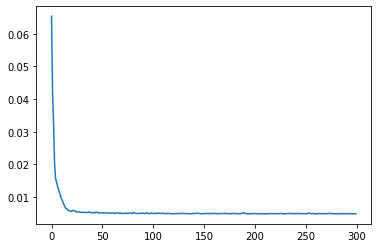

In [346]:
plt.plot(model.history.history['loss'])

np.sqrt(model.history.history['loss'][-1])

Mean -0.005599506771648473, Stdev 0.06985054065668969
Mean 2.2941877999634232e-17, Stdev 0.11643186999734959


<Figure size 432x288 with 0 Axes>

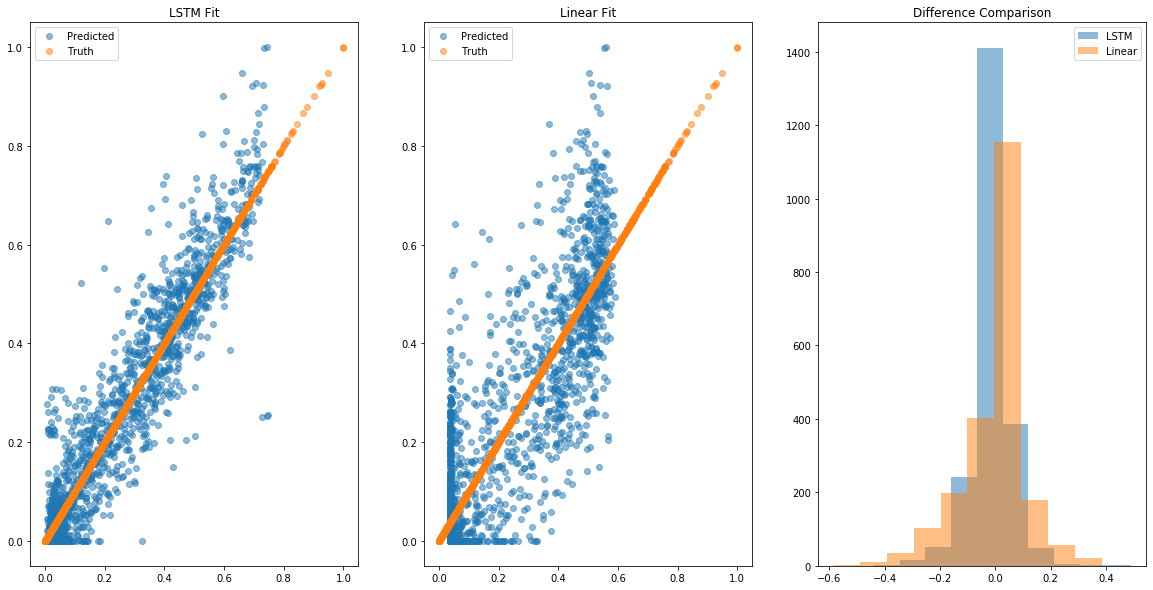

In [349]:
plt.figure()
res = model.predict(trainX.reshape(len(trainX), np.shape(trainX)[1],1))

fig, ax = plt.subplots(ncols=3, figsize=(20,10))

ax[0].plot(res,Y, 'o', label='Predicted', alpha=0.5)
ax[0].plot(y, Y, 'o', label='Truth', alpha=0.5)
ax[0].set_title("LSTM Fit")
ax[0].legend()

res = res.reshape(len(res))

ax[1].plot(Y_pred, Y, 'o',label='Predicted', alpha=0.5)
ax[1].plot(Y, Y, 'o', label='Truth', alpha=0.5)
ax[1].set_title("Linear Fit")
ax[1].legend()

ax[2].set_title("Difference Comparison")
ax[2].hist(res-y, alpha=0.5, label='LSTM', density=False)
ax[2].hist(Y_pred-Y, alpha=0.5, label='Linear', density=False)
ax[2].legend()


print("Mean {}, Stdev {}".format((res-y).mean(), (res-y).std()))
print("Mean {}, Stdev {}".format((Y_pred-Y).mean(), (Y_pred - Y).std()))


In [353]:
trainX

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

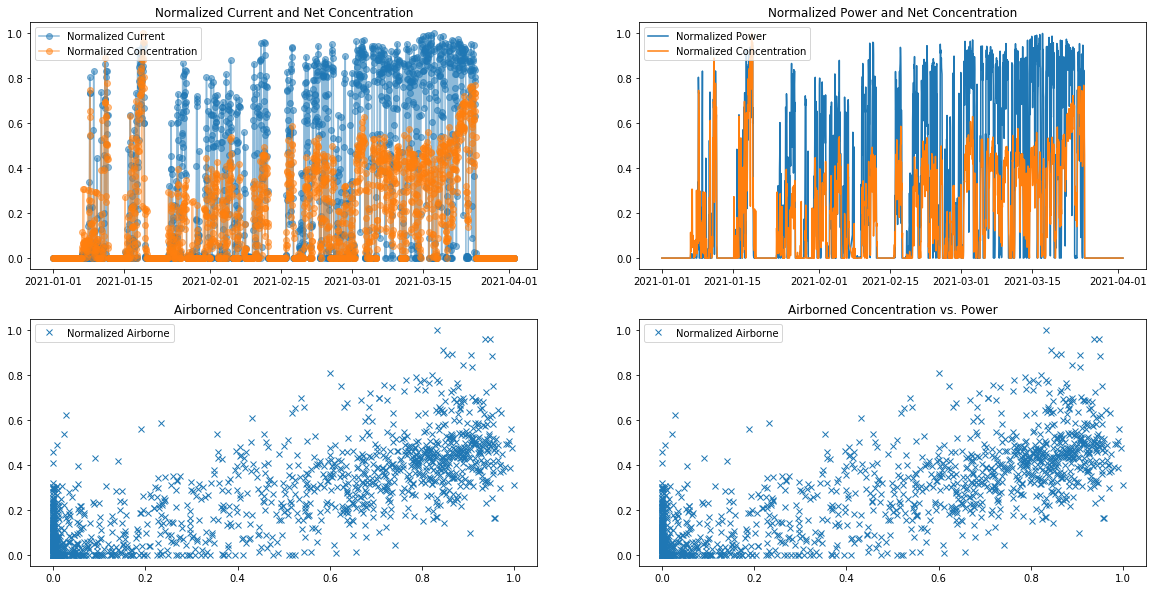

,DATE_TIME,AirMon_A_Bkg,C_A(uA),AirMon_A_Cur,E_A(MeV),net_hall_a,norm_hall_a,norm_air_hall_a
0,2021-01-01 00:30:00,9.578478e-08,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 01:30:00,9.854823e-08,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 02:30:00,1.409705e-07,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 03:30:00,9.095065e-08,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 04:30:00,6.668227e-08,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2163,2021-04-01 19:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2164,2021-04-01 20:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2165,2021-04-01 21:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0
2166,2021-04-01 22:30:00,1.304240e-08,0.0,0.0,0.0,0.0,0.0,0.0


In [289]:
air.normalize(full, hall, use_net_res=True, net_set=True)

In [ ]:
full

In [ ]:
full.plot(x='DATE_TIME', y=['C_D(nA)'])

In [ ]:
full['C_D(nA)'].hist()

In [234]:
len(df[(df['net_hall_a'] > 0 )])



1358

In [ ]:
b


In [ ]:
full.loc[:, 'DATE_TIME'] = pd.to_datetime(full['DATE_TIME'])

In [ ]:
full

0.7412305475357116

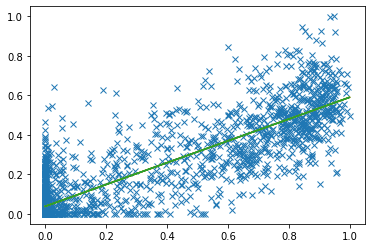

In [336]:
#full.plot(x='C_D(nA)', y=['net_hall_d'], linestyle='none', marker='o')

#fit_set = df.loc[((df['C_A(uA)'] > 1) & (df['net_hall_a'] > 0 ))]
fit_set = df.loc[((df['net_hall_a'] >= 0 ))]
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class

full.fillna(0., inplace=True)

X = np.asarray(fit_set['norm_hall_a'].values).reshape(-1,1)

#X.replace('NaN', 0.)
Y = np.asarray(fit_set['norm_air_hall_a'].values).reshape(-1,1)

#Y.replace('NaN', 0.)
linear_regressor.fit(X, Y )  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.plot(X,Y, 'x')
plt.plot(X,Y_pred)
coeff = linear_regressor.coef_
inter = linear_regressor.intercept_

plt.plot(X, (X*coeff + inter))

linear_regressor.score(X, Y)
#fit_set.plot(x='DATE_TIME', y='net_hall_a')

In [232]:
np.shape(X)

(1358, 1)

In [ ]:
print(air_df['DATE_TIME'].values)

In [ ]:
air = air_dat()
air_df = air.get_data()
air_df = air.apply_threshold(air_df, 'hall_a')

val, bkg = air.get_loc_bkg(air_df, pad=3)

fig, ax = plt.subplots()
val.plot(x='DATE_TIME', y=air.monitor['hall_a'], ax=ax)
bkg.plot(x='DATE_TIME', y=air.monitor['hall_a'], ax=ax)

In [ ]:

res = 

In [ ]:
air = air_dat()
air_df = air.get_data()
air_df = air.apply_threshold(air_df, 'hall_a')
val = air.get_loc_bkg(air_df, pad=10)
val.plot(x='DATE_TIME', y=air.current['hall_a'])



In [ ]:
# we want to resample the background data (when current for the hall is 0uA) so the data is continuous across 

bkg_df = pd.DataFrame(air_df.loc[(air_df['C_A(uA)'] < 1), 
           ['DATE_TIME', 'AirMon_A']]).set_index('DATE_TIME').resample('30Min').interpolate()

bkg_df_c = pd.DataFrame(air_df.loc[(air_df['C_C(uA)'] < 1), 
           ['DATE_TIME', 'AirMon_C']]).set_index('DATE_TIME').resample('30Min').interpolate()

bkg_df = bkg_df.merge(bkg_df_c, left_on='DATE_TIME', right_on='DATE_TIME')

#air_df.set_index('DATE_TIME')
bkg_df = bkg_df.reset_index()
bkg_df = bkg_df.merge(air_df, left_on='DATE_TIME', right_on='DATE_TIME')
bkg_df.plot(x='DATE_TIME', y=['AirMon_A_y', 'AirMon_A_x'], label=['hall_a', 'background'])
bkg_df['net_a'] = bkg_df['AirMon_A_y'] - bkg_df['AirMon_A_x']
bkg_df[bkg_df['net_a'] < 0] = 0

fig, ax = plt.subplots()
bkg_df.plot(x='DATE_TIME', y='net_a', ax=ax)
ax.set_title("Hall A Net $\mu Ci / ml$ ; total: {:2.2e}".format(bkg_df['net_a'].sum()))
plt.xticks(rotation=90)
#fig.autofmt_xdate()

#air_df.set_index('DATE_TIME')
#bkg_df = bkg_df.reset_index()
#bkg_df = bkg_df.merge(air_df, left_on='DATE_TIME', right_on='DATE_TIME')
bkg_df.plot(x='DATE_TIME', y=['AirMon_C_y', 'AirMon_C_x'], label=['hall_c', 'background'])
bkg_df['net_c'] = bkg_df['AirMon_C_y'] - bkg_df['AirMon_C_x']
bkg_df[bkg_df['net_c'] < 0] = 0

fig, ax = plt.subplots()
bkg_df.plot(x='DATE_TIME', y='net_c', ax=ax)
ax.set_title("Hall C Net $\mu Ci / ml$ ; total: {:2.2e}".format(bkg_df['net_c'].sum()))
plt.xticks(rotation=90)



In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True)
bkg_df['AirMon_A_x'].hist(ax=ax[0])

bkg_df['AirMon_A_y'].hist(ax=ax[1])

bkg_df['net_a'].hist(ax=ax[2])

In [ ]:
halla_bkg = air_df.loc[(air_df['C_A(uA)'] < 1) & (air_df['AirMon_A'] < 0.000002), 
           ['DATE_TIME', 'AirMon_A']].set_index('DATE_TIME').resample('30Min').interpolate()


In [ ]:
halla_bkg

In [ ]:
fig, ax = plt.subplots()
halla_bkg.plot(ax=ax)
air_df_sub = air_df.loc[:,air_mon_keys]
air_df_a.plot(x='DATE_TIME', y=['AirMon_A', 'C_A(uA)'], ax=ax)

In [ ]:
air_df_a.plot(x='C_A(uA)', y='AirMon_A', linestyle='none', marker='o')

In [ ]:
halla_bkg = halla_bkg.reset_index()
air_df_a = air_df_a.set_index('DATE_TIME').resample('30Min').interpolate()


In [ ]:
fig,ax = plt.subplots()
air_df_a.plot(x='DATE_TIME', y='AirMon_A',ax=ax)
halla_bkg.plot(x='DATE_TIME', y='AirMon_A', ax=ax)


In [ ]:
net_a = (air_df_a['AirMon_A'] - halla_bkg['AirMon_A'])
net_a[net_a < 0] = 0
plt.plot(air_df_a['C_A(uA)'], net_a , 'o')

In [ ]:
plt.plot(air_df_a['C_A(uA)']*air_df_a['E_A(MeV)']/1e3, net_a, 'o')